## NYPD Shooting Incident Data Report


##  Report Outline:

* Data source taken form : https://catalog.data.gov/dataset/nypd-shooting-incident-data-historic

* Question of interest, what questions want to answer before this report?
    1. I wonder what is the precentage of shooting cases that cause victims die(flag as murder).
    2. Which sub area in New York city has most cases.
    3. What about some background of thoes victims? Age ? Sex? Race?
    4. Can I use a logistic regression to predict which age group/sex is the most vulnerable ? How's the quality of the model?
    
* Data loading

* Data Visualization

* Modeling

In [45]:
library(tidyverse)
library(mapview)
library(maptools)
library(sf)
library(lubridate)

set.seed(2022)

## Step 1 Load data

In [46]:
#load data
df = read.csv('NYPD_Shooting_Incident_Data__Historic_.csv', stringsAsFactors = TRUE)
head(df)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,24050482,08/27/2006,05:35:00,BRONX,52,0,,true,,,,25-44,F,BLACK HISPANIC,1017542,255918.9,40.86906,-73.87963,POINT (-73.87963173099996 40.86905819000003)
2,77673979,03/11/2011,12:03:00,QUEENS,106,0,,false,,,,65+,M,WHITE,1027543,186095.0,40.67737,-73.84392,POINT (-73.84392019199998 40.677366895000034)
3,203350417,10/06/2019,01:09:00,BROOKLYN,77,0,,false,,,,18-24,F,BLACK,995325,185155.0,40.67489,-73.96008,POINT (-73.96007501899999 40.674885741000026)
4,80584527,09/04/2011,03:35:00,BRONX,40,0,,false,,,,<18,M,BLACK,1007453,233952.0,40.80880,-73.91618,POINT (-73.91618413199996 40.80879780500004)
5,90843766,05/27/2013,21:16:00,QUEENS,100,0,,false,,,,18-24,M,BLACK,1041267,157133.5,40.59780,-73.79469,POINT (-73.79468553799995 40.597796249000055)
6,92393427,09/01/2013,04:17:00,BROOKLYN,67,0,,false,,,,<18,M,BLACK,1001694,170112.9,40.63359,-73.93715,POINT (-73.93715330699996 40.63358818100005)


In [5]:
colnames(df)

[1] "INCIDENT_KEY"            "OCCUR_DATE"             
 [3] "OCCUR_TIME"              "BORO"                   
 [5] "PRECINCT"                "JURISDICTION_CODE"      
 [7] "LOCATION_DESC"           "STATISTICAL_MURDER_FLAG"
 [9] "PERP_AGE_GROUP"          "PERP_SEX"               
[11] "PERP_RACE"               "VIC_AGE_GROUP"          
[13] "VIC_SEX"                 "VIC_RACE"               
[15] "X_COORD_CD"              "Y_COORD_CD"             
[17] "Latitude"                "Longitude"              
[19] "Lon_Lat"

Drop some unnecessery columns.

In [48]:
df_new = df[c('OCCUR_DATE', 'BORO', 'STATISTICAL_MURDER_FLAG','VIC_AGE_GROUP', 'VIC_SEX','VIC_RACE', 'Latitude','Longitude')]
head(df_new)

,OCCUR_DATE,BORO,STATISTICAL_MURDER_FLAG,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,08/27/2006,BRONX,true,25-44,F,BLACK HISPANIC,40.86906,-73.87963
2,03/11/2011,QUEENS,false,65+,M,WHITE,40.67737,-73.84392
3,10/06/2019,BROOKLYN,false,18-24,F,BLACK,40.67489,-73.96008
4,09/04/2011,BRONX,false,<18,M,BLACK,40.80880,-73.91618
5,05/27/2013,QUEENS,false,18-24,M,BLACK,40.59780,-73.79469
6,09/01/2013,BROOKLYN,false,<18,M,BLACK,40.63359,-73.93715


## 2 Visualization and analysis

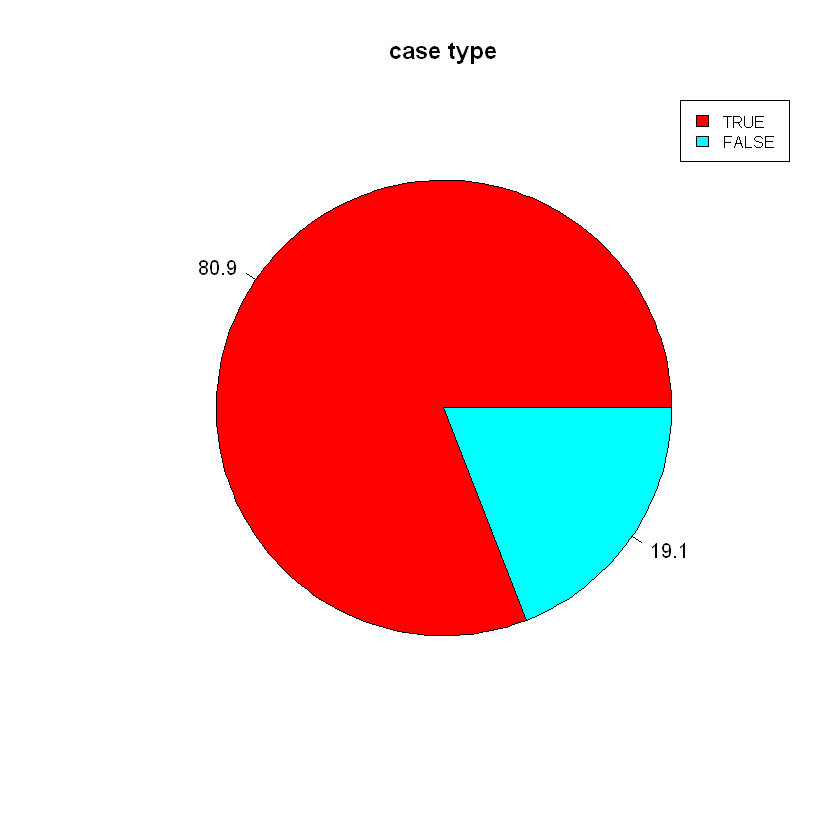

In [53]:
temp = df_new %>%
group_by(STATISTICAL_MURDER_FLAG) %>%
count()

piepercent<- round(100*temp$n/sum(temp$n), 1)
#pie(temp$n,temp$STATISTICAL_MURDER_FLAG)

pie(temp$n,label=piepercent, main = "case type",
    col = rainbow(length(temp$n)))
    legend("topright", c("TRUE", "FALSE"), cex = 0.8,
   fill = rainbow(length(temp$n)))

From the plot above we can see Non murder contribute over 80% of total cases.

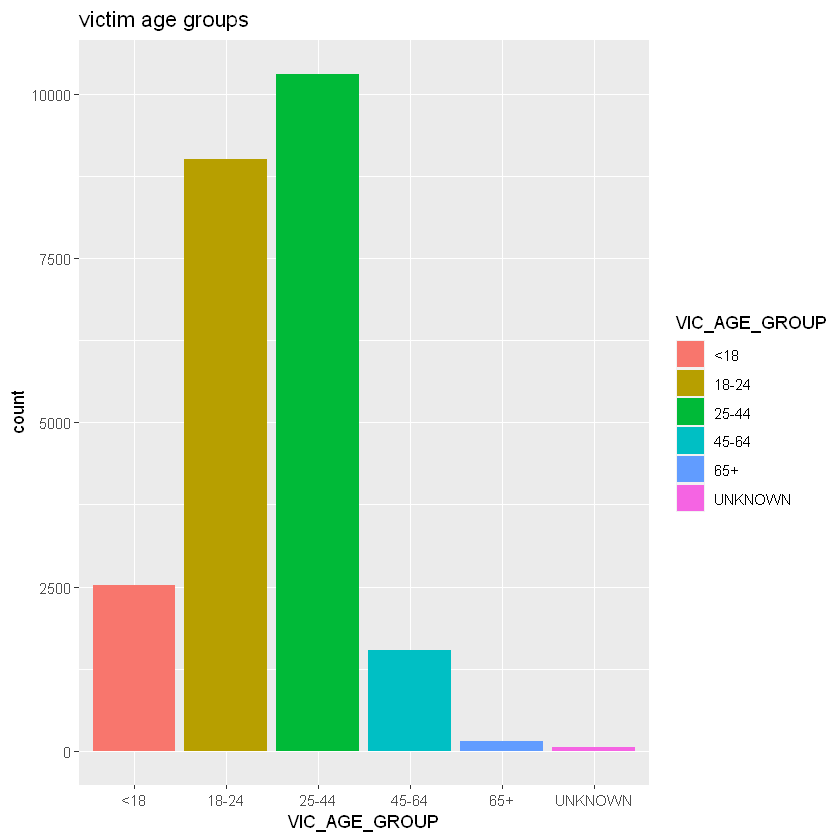

In [55]:
ggplot(df_new, aes(x=VIC_AGE_GROUP, fill=VIC_AGE_GROUP)) +  
    geom_bar(stat="count", alpha=5) + 
    labs(title='victim age groups')

From the plot above we can see most common age group fall into 25-44 with total cases close to 11000, and the second most is age between 19-24.

Brooklyn and Bronx are 2 boroughs of NYC have most shooting cases.

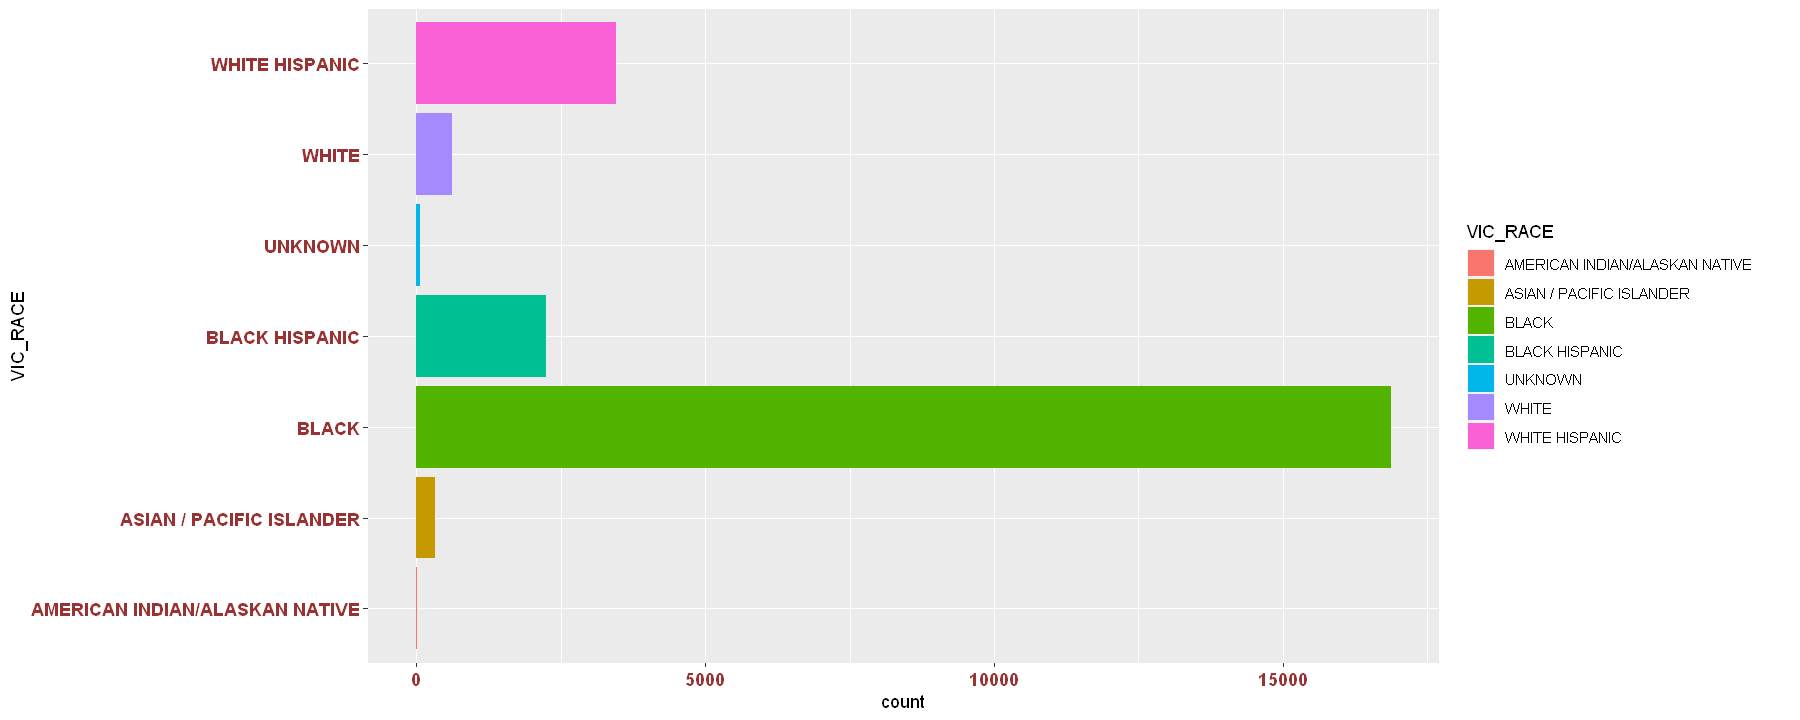

In [58]:
options(repr.plot.width=15, repr.plot.height=6) 
ggplot(df_new, aes(y=VIC_RACE, fill=VIC_RACE)) +  
    geom_bar(stat="count", alpha=5) + 
    theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=11),
          axis.text.y = element_text(face="bold", color="#993333", 
                           size=11))

options(repr.plot.width=7, repr.plot.height=7) 

From plot above ： Black and White hispanic are 2 most count cases.

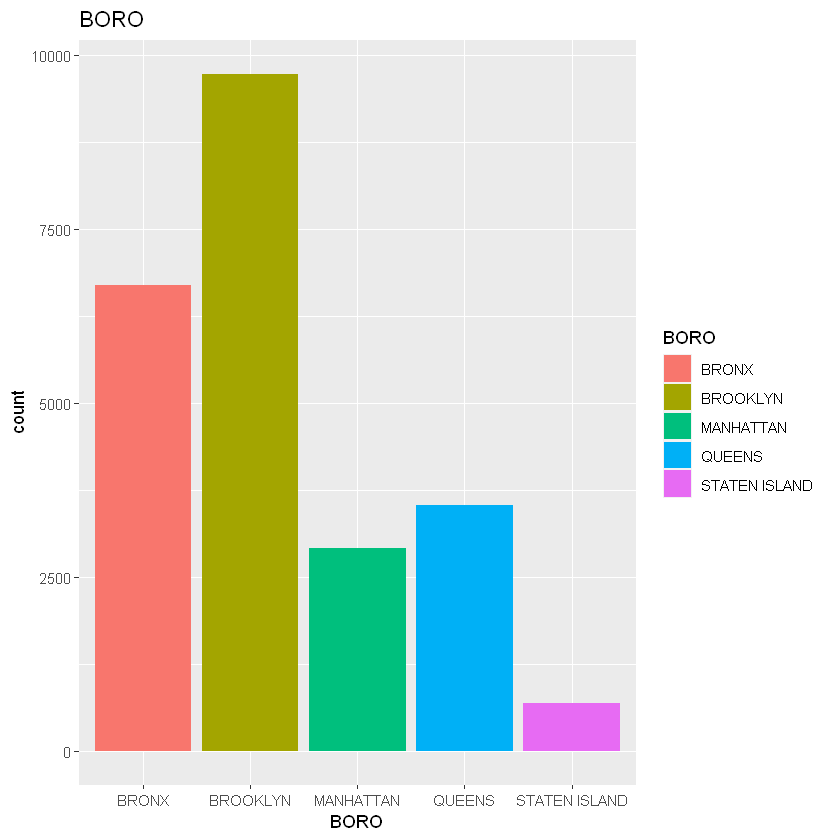

In [59]:
ggplot(df_new, aes(x=BORO, fill=BORO)) +  
    geom_bar(stat="count", alpha=5) + 
    labs(title='BORO')

To answer question 2 about which boro in NYC has most cases, the above plot is generated, Brooklyn and Bronx are most and second most cases boro in the city.

## 3 Modeling the data

In [77]:
#logistic regression on age group

trian_df = df_new[1 :23000, ]
test_df = df_new[23001: 23585, ]

mod = glm(VIC_SEX ~ BORO+VIC_AGE_GROUP, family=binomial, data=trian_df) 
summary(mod)

# options(repr.plot.width=10, repr.plot.height=10)
# par(mfrow = c(2,2))
# plot(mod)


Call:
glm(formula = VIC_SEX ~ BORO + VIC_AGE_GROUP, family = binomial, 
    data = trian_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3180   0.3868   0.4088   0.4134   0.9414  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           1.87007    0.06796  27.518  < 2e-16 ***
BOROBROOKLYN         -0.11484    0.05693  -2.017  0.04366 *  
BOROMANHATTAN        -0.12122    0.07808  -1.553  0.12051    
BOROQUEENS           -0.19917    0.07268  -2.740  0.00614 ** 
BOROSTATEN ISLAND    -0.24891    0.13116  -1.898  0.05772 .  
VIC_AGE_GROUP18-24    0.74584    0.07023  10.620  < 2e-16 ***
VIC_AGE_GROUP25-44    0.68497    0.06823  10.039  < 2e-16 ***
VIC_AGE_GROUP45-64   -0.36167    0.08663  -4.175 2.98e-05 ***
VIC_AGE_GROUP65+     -1.03705    0.18345  -5.653 1.58e-08 ***
VIC_AGE_GROUPUNKNOWN  0.59481    0.47147   1.262  0.20709    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for b

In [110]:
# attach(test_df)
# table(predicted.classes, VIC_SEX)
probabilities <- mod %>% predict(test_df, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "M", "F")

test_class = test_df$VIC_SEX

cat('Mean accuracy on test data:', mean(predicted.classes == test_class))

Mean accuracy on test data: 0.9264957

##### Analysis : 

And in above we fit a logistic regression model, use BORO+VIC_AGE_GROUP as predictors, to predict VIC_SEX, weather a victim is male or female. 

In the output model, most significant predictors are VIC_AGE_GROUP18-24, VIC_AGE_GROUP25-44,VIC_AGE_GROUP45-64 and VIC_AGE_GROUP65.

We use firt 20000 rows as training and the least as testing data, predicted.classes on test data has mean accuarcy of 0.93.



## 4 Identifying Bias  

Possible bias: 

We can see that Brooklyn is the boro that has  the most cases, further assumption and data need to collected before make any conclusion. So other factors I can think of may correlate to high number of cases, for example, is the police responding time in Brooklyn show any significant difference across the city?  What about number of guns per capita, and more.  If we make early conclusion that  the reason that Brooklyn has most cases is because those factor mention only in this data such as age/sex/race that would possibly have  bias.


## 5 Conclusion

Now we can answer those question of interest at the beginning:

1. About 80% are non murder, and the rest are murder.
2. BROOKLYN are the boro has the most cases.
3. Background of cases are clear in the plots.